In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import simpy

from scipy.stats import gamma, poisson, randint, binom, bernoulli, multinomial
plt.style.use('fivethirtyeight')


In [2]:
# import models

# attrtition model

attrition_model = joblib.load("models/attrition_model.joblib")

# reasons function

reasons_function = joblib.load("models/reason_function.joblib")

# regrettable function

regrettable_function = joblib.load("models/regrettable_function.joblib")

In [3]:
def ramping_function(week): 
    for w, tickets in enumerate([21, 27, 40, 54, 67]): 
        if week == w: 
            return tickets
    return 67

x = np.arange(0, 20, 1)
rf = np.vectorize(ramping_function)

In [4]:
ramping_function(0)

21

In [5]:
class Team: 
    def __init__(self, env, attrition_model, ramping_function): 
        self.Headcount = simpy.Container(env)
        self.Capacity = simpy.Container(env)
        self.attrition_model = attrition_model
        self.ramping_function = ramping_function
        
        
def attrit(env, N, M, record, date, team, n_weeks, init): 

    month = date.month
    if init == 1:
        pass
    else:
        team.Headcount.put(N)
        team.Capacity.put(team.ramping_function(n_weeks) * N)
    record[env.now, [n_weeks, -2]] += N
    while N > M:
        
        n_weeks += 1 # increase week
        date += pd.Timedelta(1, unit = 'W')
        month = date.month


        l = [[n_weeks, month]]
        p = team.attrition_model.predict_proba(l)[0]

        N_new = int(N*p[0])#binom.rvs(N, p)[0]
        leaving = N - N_new
        staying = N_new
        N = N_new
                
        if leaving > 0:
            team.Headcount.get(leaving)
            team.Capacity.get(team.ramping_function(n_weeks - 1) * leaving)
            
        if staying > 0: 
            team.Capacity.get(team.ramping_function(n_weeks - 1) * staying)
            team.Capacity.put(team.ramping_function(n_weeks) * staying)
            
        yield env.timeout(1)
        
        record[env.now, [n_weeks, -2]] += N

                
def sustain(env, N, K, M, record, start_date, end_date, n_weeks, target_capacity, target_headcount, 
            mode, team, changes):   
    
    date = start_date
    month = date.month
    initial_capacity = team.ramping_function(n_weeks) * (target_headcount[0])
    initial_headcount = target_headcount[0]
    N = initial_headcount

    team.Headcount.put(initial_headcount)
    record[env.now, [n_weeks-1, -1]] += N
    
    team.Capacity.put(initial_capacity)
    init = 0
    if K > 0:   
        env.process(
            attrit(env, K, 0, record, date, team, 12, 1)
        )
    
    while True: 
                
        effective_dates = pd.date_range(start = date, end = date + pd.Timedelta(6, unit = 'D'), freq = 'D')
        effective_changes = changes.loc[changes.change_date.isin(effective_dates)]

        team_size = team.Headcount.level
        current_capacity = team.Capacity.level 
        capacity_difference = initial_capacity - current_capacity
        
        
        
        if mode == 'capacity': 
            
            new_weeks = 3
 
            new_folks = capacity_difference//team.ramping_function(new_weeks)
            record[env.now - 3, [0, -2]] += new_folks
            record[env.now - 2, [1, -2]] += new_folks
            record[env.now - 1, [2, -2]] += new_folks

        elif mode == 'headcount': 
            new_folks = target_headcount[env.now] - team_size
            
            new_weeks = 0
        else: 
            raise ValueError('Not a valid mode')
        
        if new_folks > 0: 
            init += 2
            env.process(
                attrit(env, new_folks, 0, record, date, team, new_weeks, init)
            )
        
        n_weeks += 1
        date += pd.Timedelta(1, unit = 'W')
        month = date.month  
    

        l = [[n_weeks, month]]
        p = team.attrition_model.predict_proba(l)[0]

        N_new = int(N*p[0])#binom.rvs(N, p)[0]
        
        additional_loss = 0
        if len(effective_changes) > 0: 
            cohort = N_new
            for i, row in effective_changes.iterrows():
                change_amount = team_size - target_headcount[env.now]
                layoff = np.clip(int(change_amount), a_min = 0, a_max = cohort)
                cohort = cohort - layoff
                additional_loss += layoff
            
        leaving = (N - N_new) + additional_loss
        staying = N_new - additional_loss
        N = staying
        
        if leaving > 0:
            team.Headcount.get(leaving)
            team.Capacity.get(team.ramping_function(n_weeks-1) * leaving)
            
        if staying > 0: 
            team.Capacity.get(team.ramping_function(n_weeks - 1) * staying)
            team.Capacity.put(team.ramping_function(n_weeks) * staying)


        yield env.timeout(1)
        # record the headcount of this wave
        record[env.now, [n_weeks, -1]] += N
        
        
def run_simulation(N, K, attrition_model, ramping_function, target_headcount, target_capacity, start_date, end_date, mode, changes):
    M = 0
    n_weeks = 12

    sim_len = (end_date - start_date).days // 7    
    record = np.zeros((sim_len, n_weeks + sim_len + 2))

    env = simpy.Environment()
    team = Team(env, attrition_model, ramping_function)
    
    env.process(
        sustain(env, N, K, M, record, start_date, end_date, n_weeks, 
                target_headcount = target_headcount, target_capacity = target_capacity,
                team = team, mode = mode, changes = changes)
    )
    env.run(sim_len)
    
    return record

In [6]:
def scheduler_by_loc(location , targets):  
    
    target_capacity = None
    target_headcount = targets.target_headcount.values


    record = run_simulation(N, K, attrition_model, ramping_function, target_headcount, target_capacity,
                           start_date, end_date, mode = 'headcount', changes = changes)

    period = pd.date_range(start_date, end_date, freq = 'W', inclusive = 'left')
    df = pd.DataFrame(record)
    df = df.assign(
        global_capacity = np.dot(df.iloc[:, :-2].values, rf(df.iloc[:, :-2].columns).T),
        global_headcount = (df.iloc[:, -2] + df.iloc[:, -1]), 
        vovo_headcount = df.iloc[:, -2], 
        remote_headcount = df.iloc[:, -1], 
        date = period
    )

    df['weekly_attrition'] = df[0]

    LL_agg = df.copy()

    LL_agg['month'] = LL_agg.date.dt.month
    LL_agg['Year'] = LL_agg.date.dt.year
    LL_agg['Quarter'] = np.nan
    LL_agg.loc[LL_agg.month == 1, 'Quarter'] = 1
    LL_agg.loc[LL_agg.month == 4, 'Quarter'] = 2
    LL_agg.loc[LL_agg.month == 7, 'Quarter'] = 3
    LL_agg.loc[LL_agg.month == 10, 'Quarter'] = 4

    LL_agg = LL_agg.fillna(method = 'ffill')
    LL_agg['last_q'] = LL_agg['Quarter'].shift(1)

    LL_agg['cum_tix'] = LL_agg.groupby(['Quarter', 'Year']).global_capacity.cumsum()
    LL_agg['location'] = location
    
    return LL_agg


changes = {
    "1":{
        "change_date":pd.to_datetime('05/28/2024'),
        "change_amount":0.
    }
}

N = 88
K = 0
changes = pd.DataFrame(changes.values())

start_date = pd.to_datetime('04/01/2023').to_period('W').start_time + pd.Timedelta(6, unit='d')
end_date = pd.to_datetime('12/31/2023').to_period('W').start_time + pd.Timedelta(6, unit='d')

sim_period = pd.date_range(start_date, end_date, freq = 'W')

targets = pd.DataFrame(data = {'date': sim_period})
targets = targets.assign(
    target_headcount = N+K
)

targets.loc[targets.date>=pd.to_datetime('03/23/2023'), 'target_headcount'] = 72
targets.loc[targets.date>=pd.to_datetime('05/22/2023'), 'target_headcount'] = 22


LL_agg_us = scheduler_by_loc(location = 'US', targets = targets)

changes = {
    "1":{
        "change_date":pd.to_datetime('05/28/2024'),
        "change_amount":0# .5
    }
}
N = 98
K = 0
changes = pd.DataFrame(changes.values())

start_date = pd.to_datetime('04/01/2023').to_period('W').start_time + pd.Timedelta(6, unit='d')
end_date = pd.to_datetime('12/31/2023').to_period('W').start_time + pd.Timedelta(6, unit='d')

sim_period = pd.date_range(start_date, end_date, freq = 'W')

targets = pd.DataFrame(data = {'date': sim_period})
targets = targets.assign(
    target_headcount = N+K
)

targets.loc[targets.date>=pd.to_datetime('03/23/2023'), 'target_headcount'] = 78
targets.loc[targets.date>=pd.to_datetime('05/22/2023'), 'target_headcount'] = 24


LL_agg_ind = scheduler_by_loc(location = 'IND', targets = targets)

Text(0.5, 1.0, 'Cummulative Number of Tickets Resolved Per Quarter (Total)')

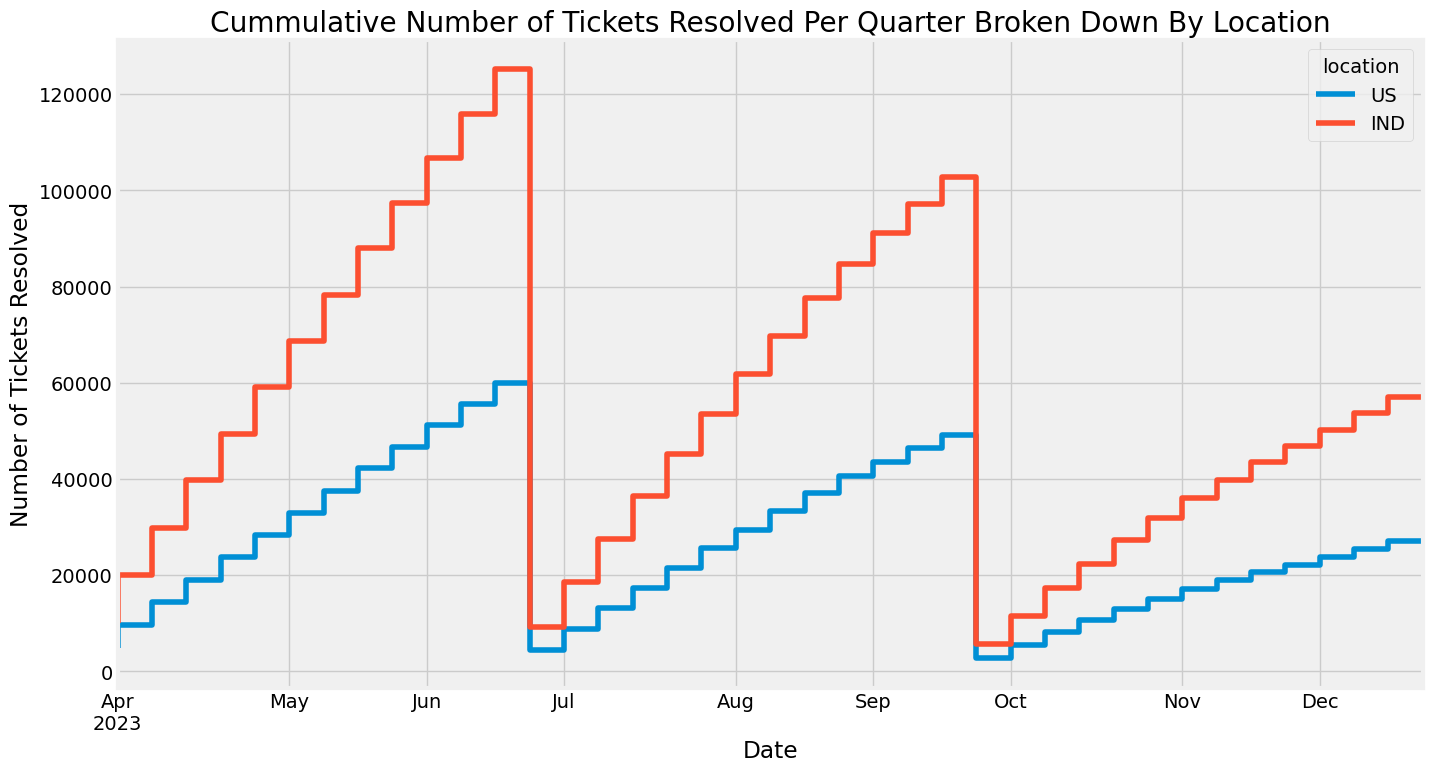

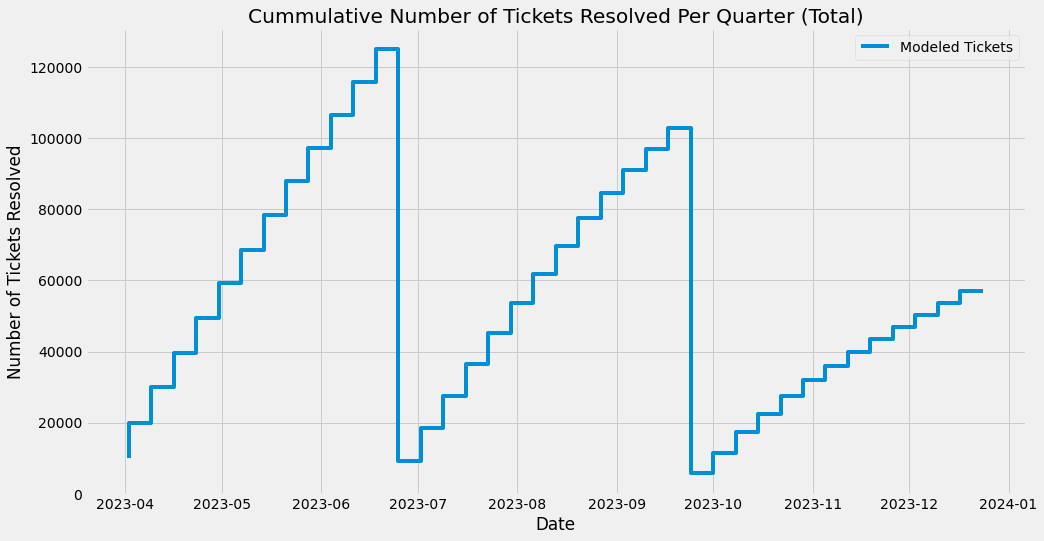

In [7]:
fig, ax = plt.subplots(figsize = (15, 8), frameon=False, dpi=100)

LL = pd.concat([LL_agg_ind, LL_agg_us], axis = 0)
LL = LL.pivot(index = ['date'], columns = 'location', values = 'cum_tix').reset_index()
LL.plot(x = 'date', y = ['US', 'IND'], stacked = True, drawstyle = 'steps-pre', ax = ax)
LL['date'] = pd.to_datetime(LL['date'])

# sns.scatterplot(data = goals, x = 'date', y = 'tickets', ax = ax, color = 'black', label = 'Expected Tickets', marker="_", s= 1000)

# for line in range(0,goals.shape[0]):
#      plt.text(goals.date[line] + pd.Timedelta(1, unit = 'W'), goals.tickets[line], transform=ax.transAxes,
#               s = goals.tickets[line], horizontalalignment='left', size='medium', color='black', weight='semibold')



# plt.stackplot(LL.date, LL.US, LL.IND)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tickets Resolved')
ax.set_title('Cummulative Number of Tickets Resolved Per Quarter Broken Down By Location')


fig, ax = plt.subplots(figsize = (15, 8))

LL = pd.concat([LL_agg_ind, LL_agg_us], axis = 0)
LL = LL.groupby(['date']).sum().cum_tix.reset_index()
LL['date'] = pd.to_datetime(LL['date'])
sns.lineplot(data = LL, x = 'date', y = 'cum_tix', ax = ax, label = 'Modeled Tickets', drawstyle = 'steps-pre')

# sns.scatterplot(data = goals, x = 'date', y = 'tickets', ax = ax, color = 'black', label = 'Expected Tickets', marker="_", s= 1000)

# for line in range(0,goals.shape[0]):
#      plt.text(goals.date[line] + pd.Timedelta(1, unit = 'W'), goals.tickets[line],
#               s = goals.tickets[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

ax.set_xlabel('Date')
ax.set_ylabel('Number of Tickets Resolved')
ax.set_title('Cummulative Number of Tickets Resolved Per Quarter (Total)')

In [8]:
LL

,date,cum_tix
0,2023-04-02,10050.0
1,2023-04-09,20008.0
2,2023-04-16,29886.0
3,2023-04-23,39710.0
4,2023-04-30,49442.0
5,2023-05-07,59160.0
6,2023-05-14,68720.0
7,2023-05-21,78332.0
8,2023-05-28,87980.0
9,2023-06-04,97362.0


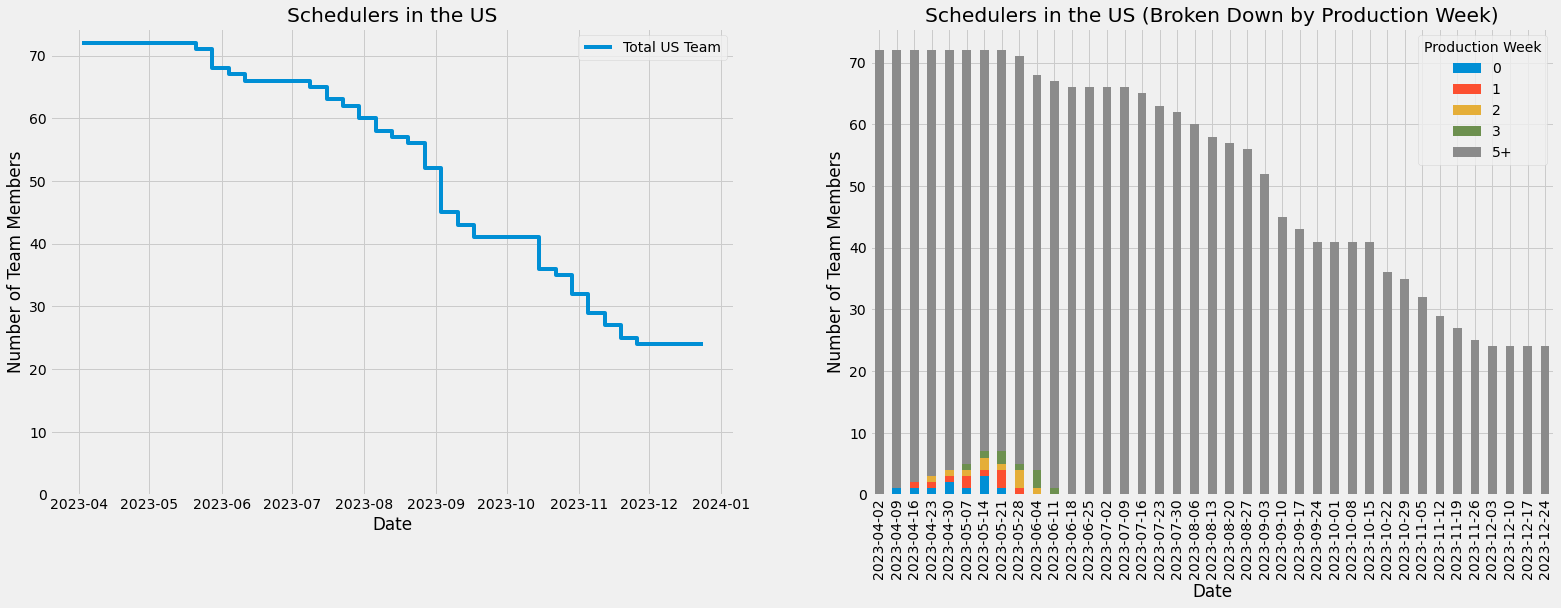

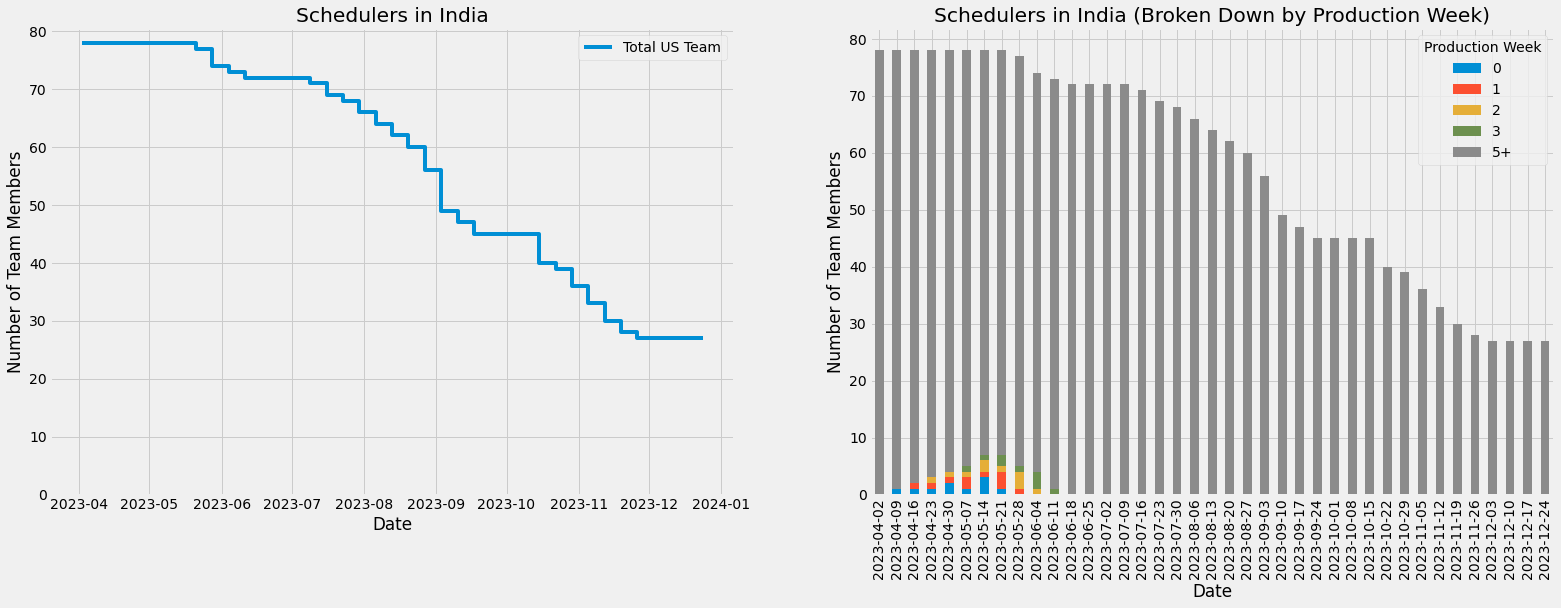

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

for LL_agg_loc, loc in zip([LL_agg_us, LL_agg_ind], ['the US', 'India']): 
    LL_agg_loc['total_team_size'] = LL_agg_loc.loc[:, 0:50].sum(axis = 1)
    LL_agg_loc['5+'] = LL_agg_loc.loc[:, 4:50].sum(axis = 1)
    LL_agg_loc['date'] = pd.to_datetime(LL_agg_loc['date']).dt.date
    fig, ax = plt.subplots(figsize = (24, 8), ncols = 2)

    sns.lineplot(data = LL_agg_loc, x = 'date', y = 'total_team_size', drawstyle = 'steps-pre', ax = ax[0], label = 'Total US Team')
    ax[0].set_ylim([0, None])
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Number of Team Members')
    ax[0].set_title(f'Schedulers in {loc}')


    LL_agg_loc[['date', 0, 1, 2, 3, '5+']].plot(kind = 'bar', stacked = True, x = 'date', ax = ax[1])
    ax[1].legend(title = 'Production Week')

    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Number of Team Members')
    ax[1].set_title(f'Schedulers in {loc} (Broken Down by Production Week)')

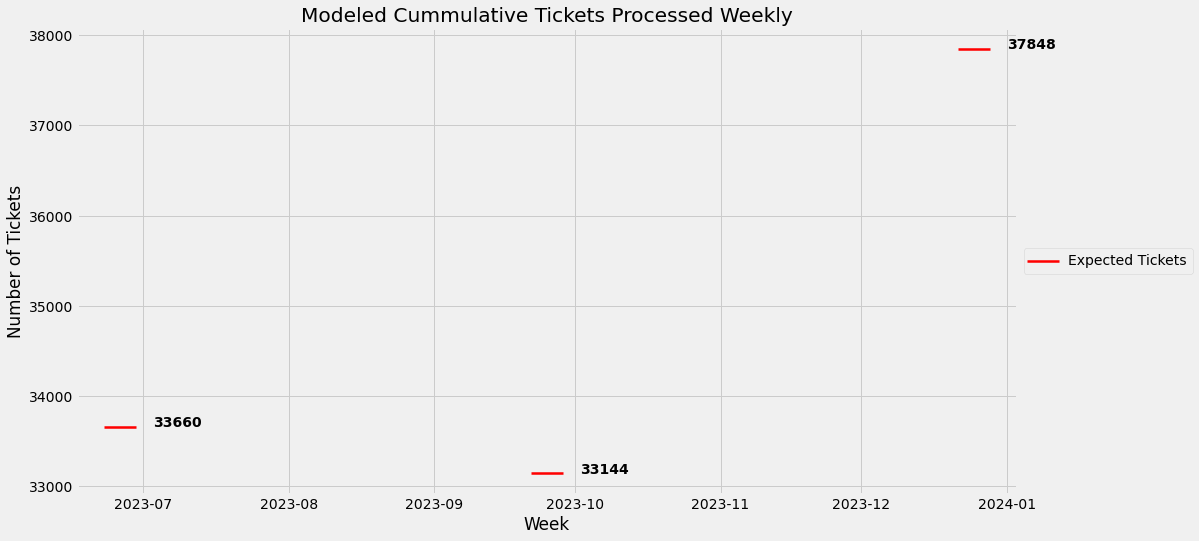

In [40]:
fig, ax = plt.subplots(figsize = (15, 8))

# LL_agg_ = LL_agg.loc[LL_agg['date'] >= pd.to_datetime('03/30/2023')]
# sns.lineplot(data = LL_aggy, x = 'date', y = 'cum_tix', ax = ax, label = 'Modeled Tickets', drawstyle = 'steps-pre')
# ax.fill_between(x = LL_agg_.date, y1 = LL_agg_.tickets_min_q_adjusted, y2 = LL_agg_.tickets_max_q_adjusted, color = 'blue', alpha = 0.1, step = 'pre')

goals = pd.DataFrame(
    data = [
        # {'tickets': 30444, 'date': pd.to_datetime('03/26/2023')},
        {'tickets': 33660, 'date': pd.to_datetime('06/26/2023').date()},
        {'tickets': 33144, 'date': pd.to_datetime('09/25/2023').date()},
        {'tickets': 37848, 'date': pd.to_datetime('12/25/2023').date()},
    ]
  )

sns.scatterplot(data = goals, x = 'date', y = 'tickets', ax = ax, color = 'red', label = 'Expected Tickets', marker="_", s= 1000)

for line in range(0,goals.shape[0]):
     plt.text(goals.date[line] + pd.Timedelta(1, unit = 'W'), goals.tickets[line], s = goals.tickets[line], horizontalalignment='left', size='medium', color='black', weight='semibold')


ax.set_xlabel('Week')
ax.set_ylabel('Number of Tickets')
ax.set_title('Modeled Cummulative Tickets Processed Weekly')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [41]:
goals

,tickets,date
0,33660,2023-06-26
1,33144,2023-09-25
2,37848,2023-12-25


NameError: name 'hc_cap' is not defined

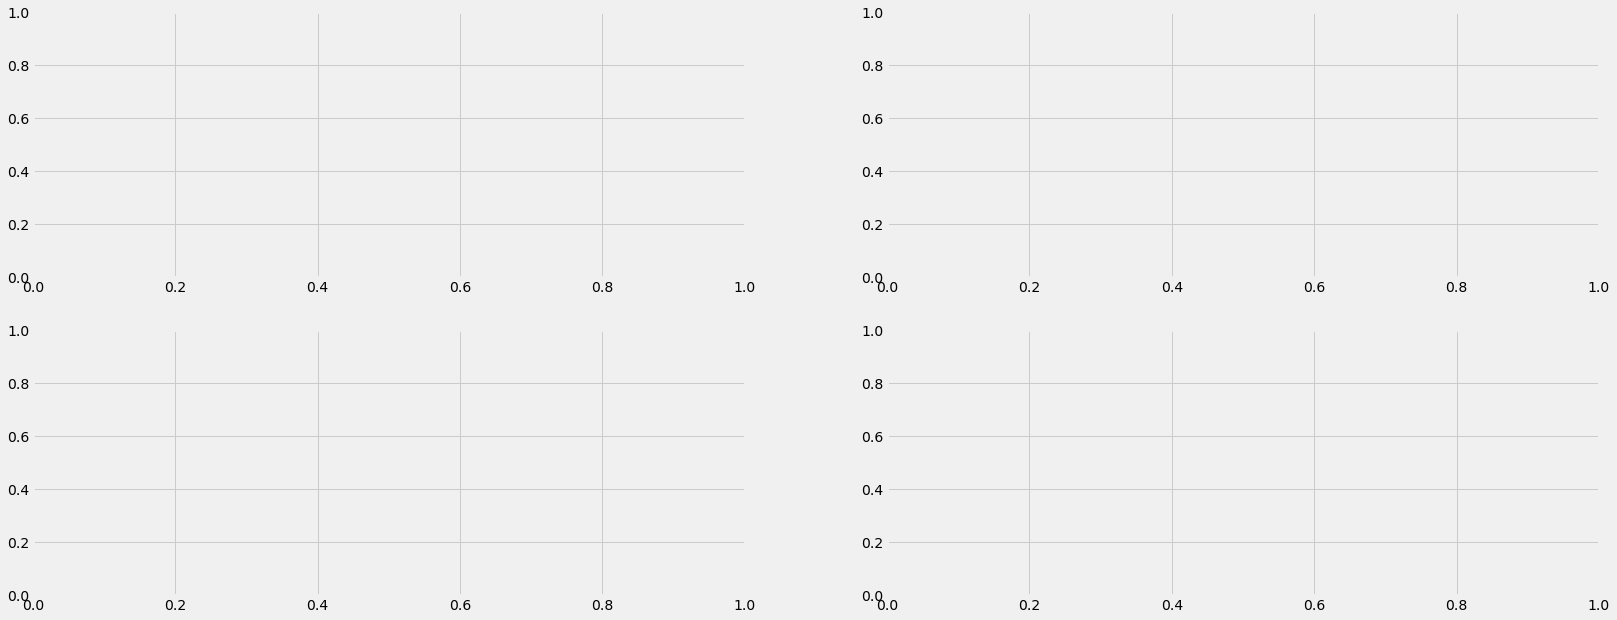

In [20]:
fig, ax = plt.subplots(figsize = (25, 10), ncols = 2, nrows = 2)

sns.lineplot(data = hc_cap, x = 'date', y = 'Capacity (Percent)', ax = ax[0, 0], drawstyle = 'steps-pre')
sns.lineplot(data = hc_cap, x = 'date', y = 'Baseline Capacity', ax = ax[0, 0], drawstyle = 'steps-pre')
sns.lineplot(data = hc_cap, x = 'date', y = 'Headcount', ax = ax[0, 1], drawstyle = 'steps-pre')
sns.lineplot(data = hc_cap, x = 'date', y = 'Baseline Headcount', ax = ax[0, 1], drawstyle = 'steps-pre')
sns.lineplot(data = hc_cap, x = 'date', y = 'Online Headcount', ax = ax[0, 1], drawstyle = 'steps-pre')
ax[0, 0].set_ylim(0, None)
ax[0, 1].set_ylim(0, None)

vovo_workforce.groupby(['date'], as_index = False)['Headcount'].sum()\
.plot(kind = 'bar', x = 'date', y = 'Headcount', ax = ax[1, 1])

remote_workforce\
.plot(kind = 'bar', x = 'date', y = 'Headcount', ax = ax[1, 0])

plt.show()

In [998]:
LL = pd.DataFrame(L)#.plot(y = 'Headcount', x = 'date')
LL['Capacity'] = LL.apply(lambda row: row.Headcount * ramping_function(row.n_weeks), axis = 1)
LL['Training'] = 'Stage 1'
LL['Training'] = LL['Training'].where(LL['n_weeks'] == 0, 'Stage 2')\
.where(LL['n_weeks'] < 2, 'Stage 3')\
.where(LL['n_weeks'] < 3, 'Stage 4')\
.where(LL['n_weeks'] < 4, 'Stage 5')\

LL
remote_workforce = LL.loc[LL.wave == 0]
atl_workforce = LL.loc[LL.wave != 0]

hc_cap = LL.groupby('date').agg(
    Headcount = ('Headcount', 'sum'), 
    Capacity = ('Capacity', 'sum'), 
    cap = ('cap', 'min')
).reset_index()



<AxesSubplot:xlabel='date', ylabel='Headcount'>

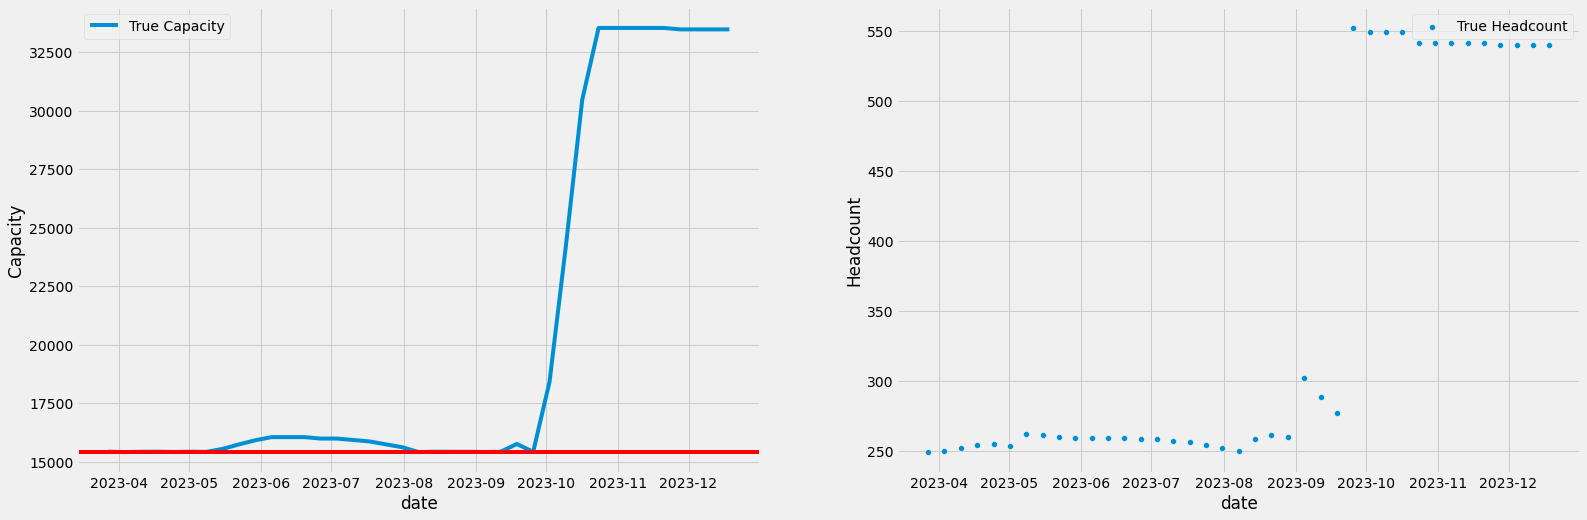

In [999]:
fig, ax = plt.subplots(figsize = (24, 8), ncols = 2)
sns.lineplot(data = hc_cap, x = 'date', y = 'Capacity', ax = ax[0], label = 'True Capacity')
#sns.lineplot(data = hc_cap, x = 'date', y = 'cap', ax = ax[0], label = 'Online Capacity')
ax[0].axhline(initial_capacity, label = 'initial capacity', color = 'red')
sns.scatterplot(data = hc_cap, x = 'date', y = 'Headcount', ax = ax[1], label = 'True Headcount')


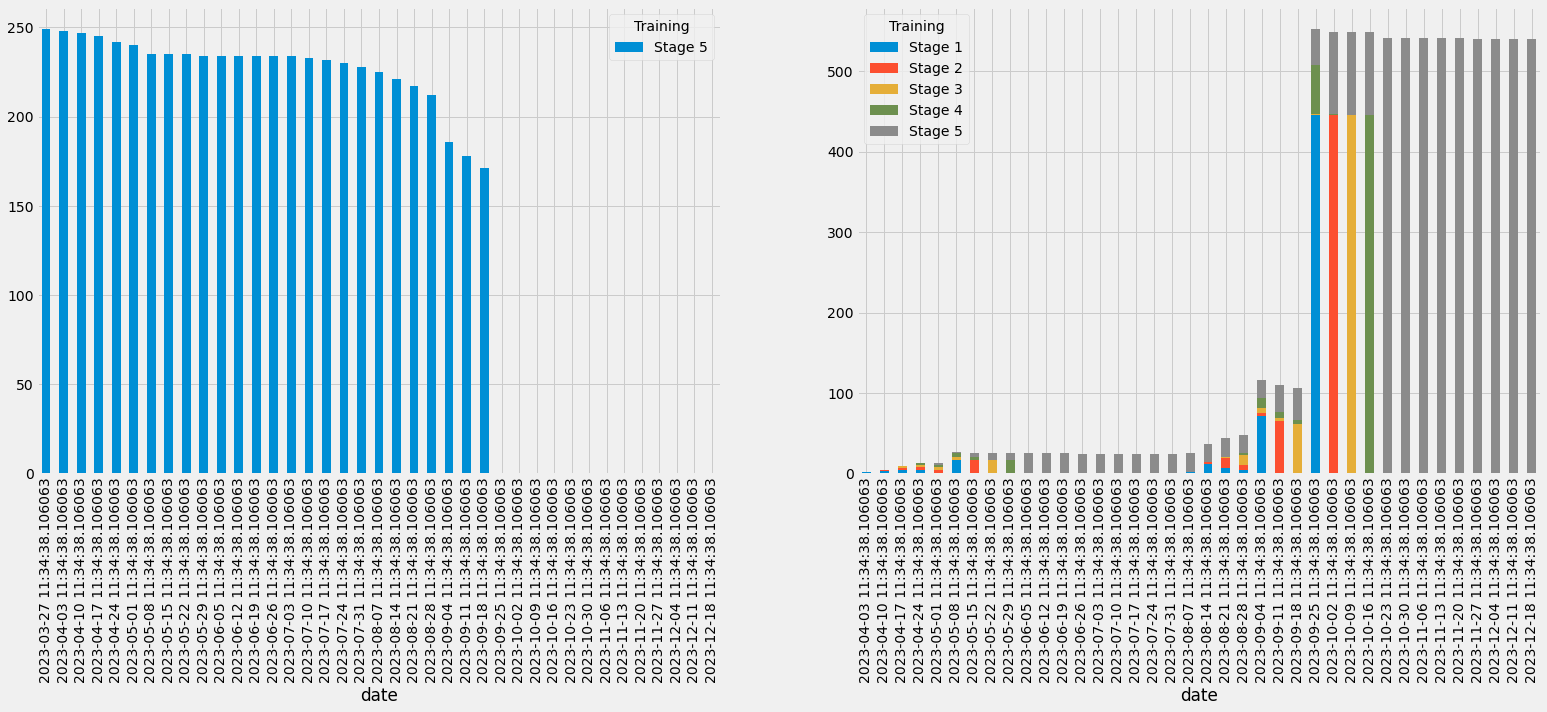

In [1000]:
fig, ax = plt.subplots(figsize = (24, 8), ncols = 2)
for i, d in enumerate([remote_workforce, atl_workforce]): 
    df = d.groupby(['date', 'Training'], as_index = False)['Headcount'].sum()
    df_pivot = df.pivot(index = 'date', columns = 'Training', values = 'Headcount').reset_index()
    
    df_pivot.plot(kind = 'bar', stacked = True, x = 'date', ax = ax[i])

In [855]:
vovo = atl_workforce.groupby(['date'], as_index = False)['Headcount'].sum()
vovo

,date,Headcount
0,2023-04-16 18:53:24.560001,5
1,2023-04-23 18:53:24.560001,19
2,2023-04-30 18:53:24.560001,19
3,2023-05-07 18:53:24.560001,19
4,2023-05-14 18:53:24.560001,16
5,2023-05-21 18:53:24.560001,13
6,2023-05-28 18:53:24.560001,16
7,2023-06-04 18:53:24.560001,16
8,2023-06-11 18:53:24.560001,16
9,2023-06-18 18:53:24.560001,16


In [810]:
s = 'Cap'
s.lower()

'cap'

In [33]:
actuals = pd.read_csv('actuals.csv')

In [34]:
actuals.head(40)

,Workstream,Role,HC VOVO 1,HC VOVO 2,Non-VOVO HC,Total HC (VOVO Aligned + Non-VOVO),Location
0,GBOFx,Sourcer/Recruiter,9.0,6.0,58,73,North America
1,GBOFx,Team Lead,0.0,0.0,8,8,North America
2,GBOFx,Business Analyst,0.0,0.0,2,2,North America
3,GBOFx,Quality Auditor,1.0,2.0,4,7,North America
4,GBOFx,Trainer,1.0,NaN,1,2,North America
5,GBOFx,Ops Manager,0.0,0.0,2,2,North America
6,GBOFx,Total,11.0,8.0,75,94,North America
7,Horizontals,Sourcer/Recruiter,4.0,1.0,56,61,North America
8,Horizontals,Team Lead,0.0,0.0,4,4,North America
9,Horizontals,Business Analyst,0.0,0.0,1,1,North America


In [36]:
actuals = actuals.fillna(0)
actuals['vovo_aligned'] = actuals['HC VOVO 1'] + actuals['HC VOVO 2']
actuals.to_csv('actuals.csv')

In [39]:
actuals = pd.read_csv('actuals.csv')

In [40]:
actuals

,Unnamed: 0,Workstream,Role,HC VOVO 1,HC VOVO 2,Non-VOVO HC,Total HC (VOVO Aligned + Non-VOVO),Location,vovo_aligned
0,0,GBOFx,Sourcer/Recruiter,9.0,6.0,58,73,North America,15.0
1,1,GBOFx,Team Lead,0.0,0.0,8,8,North America,0.0
2,2,GBOFx,Business Analyst,0.0,0.0,2,2,North America,0.0
3,3,GBOFx,Quality Auditor,1.0,2.0,4,7,North America,3.0
4,4,GBOFx,Trainer,1.0,0.0,1,2,North America,1.0
...,...,...,...,...,...,...,...,...,...
135,135,Scheduling,Business Analyst,1.0,2.0,0,3,APAC,3.0
136,136,Scheduling,Quality Auditor,17.0,0.0,0,17,APAC,17.0
137,137,Scheduling,Trainer,5.0,0.0,0,5,APAC,5.0
138,138,Scheduling,Ops Manager,2.0,1.0,0,3,APAC,3.0
